In this notebook we compare the predictions of a linear regression transformer with skewed data. We visualize the predictions of the transformer along a randomly chosen direction. Unlike the non-skewed data case, we can see that the predictions can differ wildly from the correct linear regression, and that the predictions may not even look like a linear regression. 

In [1]:
from collections import OrderedDict
import re
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import * 
from plot_utils import *
from models import *
from samplers import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

In [2]:
run_dir = "./models"

df = read_run_dir(run_dir)
task = "linear_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above
run_path = os.path.join(run_dir, task, run_id)

model, conf = get_model_from_run(run_path)

In [3]:
from samplers import get_data_sampler
from tasks import get_task_sampler

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)

result = build_evals(conf)
skewed_sampler = GaussianSampler(n_dims=20, scale=result['skewed']['data_sampler_kwargs']['scale'])
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [4]:
def plot_skewed_visualization():
    task = task_sampler()
    task.w_b = task.w_b.index_select(0, torch.tensor([0])).repeat(task.w_b.shape[0], 1,1)

    xs = skewed_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
    ys = task.evaluate(xs)

    fcoord = torch.randn((64,1)) 
    vec = torch.randn((1,20))

    xval = torch.zeros((64,41,20))
    xval[:,:40,:] = xs[0,:40,:].repeat(64,1,1)

    xval[:,40,:] = fcoord * vec


    yval = task.evaluate(xval)

    with torch.no_grad():
        predval = model(xval, yval)


    pred = predval[:,40].detach().numpy()
    real = yval[:,40].detach().numpy()

    m, b = np.polyfit(fcoord[:,0], pred.reshape(-1,1), 1)

    #use red as color for regression line
    x = np.arange(fcoord.min(),fcoord.max(),0.01)
    plt.plot(x, m*x+b, color='red')

    plt.scatter(fcoord, pred, label="Transformer", color="orange")
    plt.scatter(fcoord, real, label="Real linear regression", color="blue")
    plt.legend()
    plt.show()

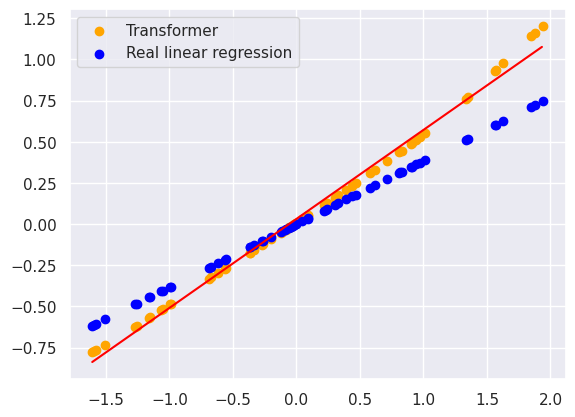

In [5]:
plot_skewed_visualization()

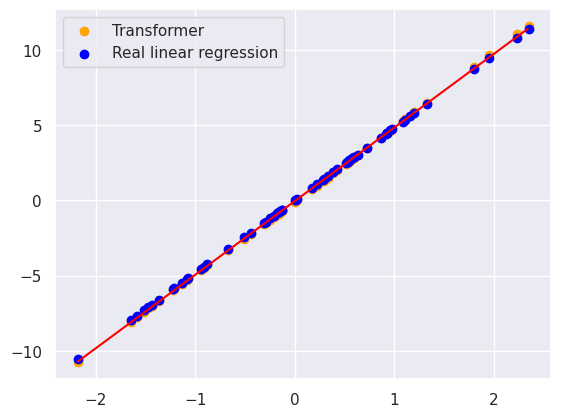

In [6]:
plot_skewed_visualization()

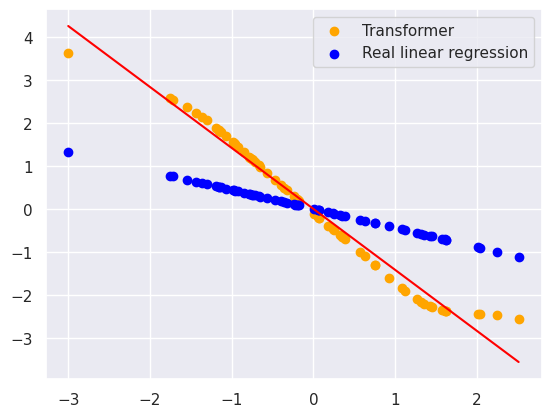

In [7]:
plot_skewed_visualization()

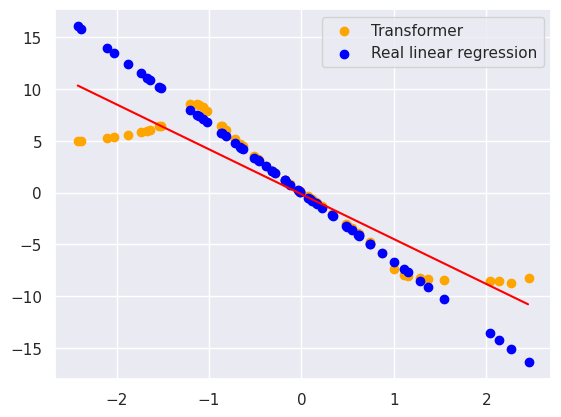

In [8]:
plot_skewed_visualization()

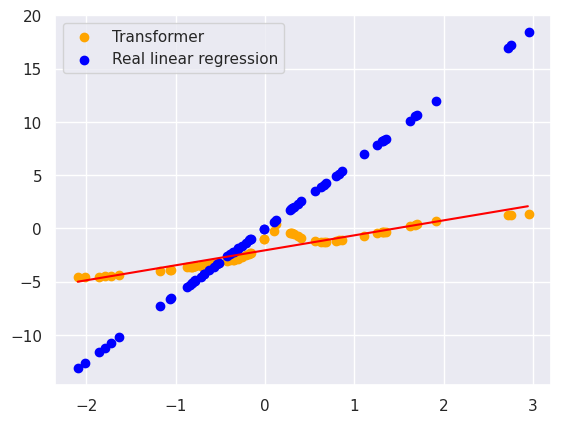

In [9]:
plot_skewed_visualization()